<a href="https://colab.research.google.com/github/tatyana-pichugina/Card_Model/blob/main/Copy_of_Training_Card_BaseModel_July2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import os
import subprocess
import sys
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
import zipfile
from torchvision import models
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader
import json


##############################################################################
print("check environment ")
##############################################################################

if 'COLAB_GPU' in os.environ:
   print("I'm running on Colab")

   def install(package):
       subprocess.check_call([sys.executable, "-m", "pip", "install", package])

   print("Cuda available",torch.cuda.is_available())
   print("installing required packages ...")
   install("segmentation-models-pytorch")
   install("lightning")
   install("wandb")
   install("onnx")
   install("albumentations")


import segmentation_models_pytorch as smp
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings('ignore')

import pytorch_lightning as pl
from lightning.pytorch.utilities.model_summary import ModelSummary
from pytorch_lightning.loggers import WandbLogger

import wandb

##############################################################################
print("Initialize WandB run ")
##############################################################################

# Model Setup
N_EPOCH=100
ENCODER = 'resnet18'
Frozen_Encoder_Flag=True
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['card']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation


LEARNING_RATE=0.1 #3.4e-4
BATCH_SIZE=64
LOSS_TYPE='DiceLoss'
MODEL_SAVE_NAME="Unet_resnet18_"
DATASET="Dataset_July2023_train213_val31:v0"


config={ #model
        "architecture": "Unet",
        "encoder":ENCODER,
        "frozen_encoder":Frozen_Encoder_Flag,
        "encoder_weights":ENCODER_WEIGHTS,
        "classes":CLASSES,
        "activation":ACTIVATION,
        # loss
        "loss":"DiceLoss",
        "metrics":"IoU",
        #optimiser
        "learning_rate": LEARNING_RATE,
        #dataset
        "dataset": DATASET,
        # calculation details
        "epochs": N_EPOCH,
        "batch_size":BATCH_SIZE}

run=wandb.init(project="Card_detection",
           notes="wandb setup",
           config=config,
           tags=ENCODER)


##############################################################################
print("Manage dataset")
##############################################################################

if 'COLAB_GPU' in os.environ:

   from google.colab import drive
   drive.mount('/content/drive')


   def load_data_to_tmp(folder_name):
    zip_ref = zipfile.ZipFile('/tmp/'+folder_name, 'r') #Opens the zip file in read mode
    zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
    zip_ref.close()

   print("dowload data from the wandb")
   artifact = run.use_artifact('team-invonto/Card_detection/Dataset_July2023_train213_val31:v0', type='compressed_480x320')
   artifact.download('/tmp/')
   load_data_to_tmp('Train.zip')
   load_data_to_tmp('Validation.zip')
   data_path='/tmp/'


else:
   data_path='/home/tatyana/Work_Invonto/Dataset/Card_Dataset/Dataset_ready_July2023'
   print('running local')

check environment 
I'm running on Colab
Cuda available True
installing required packages ...


wandb: Currently logged in as: tatyana-pichugina (team-invonto). Use `wandb login --relogin` to force relogin


Initialize WandB run 


Manage dataset
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dowload data from the wandb


wandb: Downloading large artifact Dataset_July2023_train213_val31:v0, 73.86MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.3


# Dataset


In [7]:
class CardDataset(Dataset):
    """NailDataset dataset.
    img generator that take file names and selected poligons from csv_file
    """

    def __init__(self, csv_file, root_dir, transform=None, augmentation=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.

            nail_dataset[img_number_in_csv][1] -image
            nail_dataset[img_number_in_csv][0] -corresponding mask image
        """
        self.nail_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return self.nail_frame.shape[0]

    def __getitem__(self, idx):
        file_id=self.nail_frame.iloc[idx]["filename"]
        #"read image"
        img_name = os.path.join(self.root_dir,self.nail_frame.iloc[idx]["filename"])
        img_name=img_name.split('.')[0]+'.png'
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # read mask
        mask_name=os.path.join(self.root_dir,self.nail_frame.iloc[idx]["mask"])
        mask = cv2.imread(mask_name,cv2.IMREAD_UNCHANGED)

        # required for albumentation
        mask = mask.astype(np.float32)
        mask[mask == 0] = 0.0
        mask[mask == 255] = 1.0

        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image = sample['image']
            mask=sample['mask']
            mask=mask.unsqueeze(0)

        return image,mask

train_transform=A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=cv2.BORDER_CONSTANT),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()])


validation_transform =A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()])

n_cpu=2
Number of training samples: 212
Number of validation samples: 30
torch.Size([64, 3, 480, 320]) torch.Size([64, 1, 480, 320])


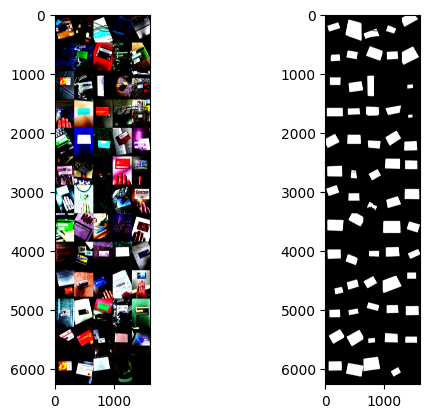

In [8]:
n_cpu = os.cpu_count()
print("n_cpu={}".format(n_cpu))

#train
x_train_path=os.path.join(data_path,'Train')
y_train_dataloader=os.path.join(x_train_path,'Train_DataLoader.csv')
#y_train_dataloader=os.path.join(x_train_path,'Train_DataLoader_sample96.csv')

train_dataset = CardDataset(y_train_dataloader, x_train_path,transform=train_transform, augmentation=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,num_workers=n_cpu)
print('Number of training samples:', len(train_dataset))

# validation
x_valid_path = os.path.join(data_path, 'Validation')
y_valid_dataloader = os.path.join(x_valid_path, 'Validation_DataLoader.csv')
valid_dataset = CardDataset(y_valid_dataloader,x_valid_path,transform=validation_transform, augmentation=None)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False,num_workers=n_cpu)
valid_dataset_vis=CardDataset(y_valid_dataloader, x_valid_path)
print('Number of validation samples:', len(valid_dataset))


# show one batch
batch_img,batch_mask=next(iter(train_loader))
print(batch_img.shape,batch_mask.shape)

fig,ax=plt.subplots(nrows=1,ncols=2)
grid_img = torchvision.utils.make_grid(batch_img, nrow=5)
ax[0].imshow(grid_img.permute(1, 2, 0))
grid_mask = torchvision.utils.make_grid(batch_mask, nrow=5)
ax[1].imshow(grid_mask.permute(1, 2, 0))


# Model U-Net
https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb

In [9]:
class CardModel(pl.LightningModule):

    def __init__(self,arch,encoder_name,encoder_weights,learning_rate,frozen_encoder=True):
        super().__init__()
        self.lr=learning_rate
        self.save_hyperparameters()
        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            classes=1,
            #activation='sigmoid'
            )

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE,from_logits=True)

        if frozen_encoder==True:
            for child in self.model.encoder.children():
                for param in child.parameters():
                    param.requires_grad = False


    def forward(self, image):
        mask = self.model(image)
        return mask

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)

        pred_mask=(output_mask.sigmoid() >= 0.5).float()



        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        train_batch_dictionary={"tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}

        self.training_step_outputs.append(train_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("train_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def train_epoch_end(self):
        # aggregate step metics
        outputs=self.training_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image)
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "train_per_image_iou": per_image_iou,
        #    "train_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.training_step_outputs.clear()



    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward

        image=batch[0]
        # assert image (batch_size,num_channels,height,width)
        assert image.ndim == 4
        # assert the image dim is suitable for Unet
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask=batch[1]
        assert mask.ndim == 4
        assert mask.max()<=1 and  mask.min()>=0 # check that the mask between [0,1] not in range [0,255]

        # calculate loss
        output_mask = self.forward(image)
        loss=self.loss_fn(output_mask,mask)

        pred_mask=(output_mask.sigmoid() >= 0.5).float()


        # calculate logs
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        validation_batch_dictionary={"loss":loss,
                          "tp":tp,
                          "fp":fp,
                          "fn":fn,
                          "tn":tn}

        self.validation_step_outputs.append(validation_batch_dictionary)
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger
        self.log("valid_loss", loss, on_epoch=True, prog_bar=True, logger=True)

        return loss


    def on_validation_epoch_end(self):
        # aggregate step metics
        outputs= self.validation_step_outputs
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])


        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise") # mean (per image)
        #dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro") # sum tp,fp,fn,tn over all dataset

        metrics = {
            "validation_per_image_iou": per_image_iou,
            #"validation_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=(self.lr or self.learning_rate))


########################################################################################################
card_model = CardModel("Unet", ENCODER,ENCODER_WEIGHTS,LEARNING_RATE,frozen_encoder=Frozen_Encoder_Flag)
#ModelSummary(card_model,max_depth=1)



card_model = CardModel("Unet", "resnet34","imagenet",LEARNING_RATE,frozen_encoder=Frozen_Encoder_Flag)


wandb_logger = WandbLogger(project="Card_detection")
trainer = pl.Trainer(max_epochs=N_EPOCH,
                     logger=wandb_logger,
                     log_every_n_steps=1,
                     default_root_dir="/content/drive/MyDrive/Dataset/")
trainer.fit(
    model=card_model,
    train_dataloaders=train_loader,
    val_dataloaders=valid_loader)


#trainer.save_checkpoint("/content/drive/MyDrive/Dataset/card_model.ckpt")
# wandb.save("/content/drive/MyDrive/Dataset/card_model.ckpt")

name="CardModel_UnetResNet18_"+run.id
path = "/content/drive/MyDrive/Dataset/"
model_name=path+name+'.onnx'
torch.onnx.export(card_model,
                  torch.randn(1,3,480,320).to('cpu'),
                  model_name,
                  input_names = ['input'],              # the model's input names
                  output_names = ['output'])
#wandb.save(model_name)

wandb.finish()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
3.2 M     Trainable params
21.3 M    Non-trainable params
24.4 M    Total params
97.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss_epoch,█▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_step,█▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,██▅▂▂▂▂▂▂▂▁▃▁▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
validation_per_image_iou,▁▁▃▆▇▇▇▇▇▇▇▆█▇██▇█▇▇▇█████████▇█████████
epoch,99
train_loss_epoch,0.02304
train_loss_step,0.01626
trainer/global_step,299
valid_loss,0.06051


In [5]:
N_EPOCH

10

In [ ]:
# name="CardModel_UnetResNet18_"+run.id
# path = "/content/drive/MyDrive/Dataset/"
# model_name=path+name+'.onnx'
# torch.onnx.export(card_model,
#                   torch.randn(1,3,480,320).to('cpu'),
#                   model_name,
#                   input_names = ['input'],              # the model's input names
#                   output_names = ['output'])
# #wandb.save(model_name)

# wandb.finish()

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▇▆▅▄▃▂▂▁▁
train_loss_step,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▅▄▃▃▃▃▃▃▂▂▂▂▂▁▁▂▁▂▂▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,██▇▅▃▂▂▁▁▃
validation_per_image_iou,▁▁▂▅▇▇▇██▆
epoch,9
train_loss_epoch,0.14754
train_loss_step,0.13372
trainer/global_step,59
valid_loss,0.31182
